## Incorrect Version. scroll down for Correct version

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import CLIPProcessor, CLIPModel

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# Threshold for mismatch detection (tunable)
SIMILARITY_THRESHOLD = 0.25

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def load_image_from_url(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content)).convert("RGB")

def check_image_text_mismatch(data):
  provider = data["message"]["catalog"]["bpp/providers"][0]
  image_url = provider["descriptor"]["images"][0]
  short_desc = provider["descriptor"]["short_desc"]

  # Load and show the image
  image = load_image_from_url(image_url)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f"Image from URL:\n{image_url}")
  plt.show()

  # Encode image and text
  inputs = processor(text=[short_desc], images=image, return_tensors="pt", padding=True)
  outputs = model(**inputs)

  logits_per_image = outputs.logits_per_image
  similarity = logits_per_image.softmax(dim=1).item()

  # Check similarity
  if similarity < SIMILARITY_THRESHOLD:
    return {
      "code": "99010",
      "message": "Description does not match predicted category: FOODS AND BEVERAGES > SNACKS > SAMOSA",
      "path": "short_description path(address)",
      "test_type": "recommendation",
      "type": "Image-Text Matching Error"
    }
  else:
    return {
      "code": "00000",
      "message": "Image and text are matching",
      "path": "short_description path(address)",
      "test_type": "passed",
      "type": "Image-Text Match"
    }

In [ ]:
# Example Input
sample_input = {
  "message": {
    "catalog": {
      "bpp/providers": [
        {
          "descriptor": {
            "images": ["https://cdn.pixabay.com/photo/2014/02/03/11/31/medications-257336_1280.jpg"],
            "long_desc": "combo of wings and burger",
            "short_desc": "fried combo"
          }
        }
      ]
    }
  }
}

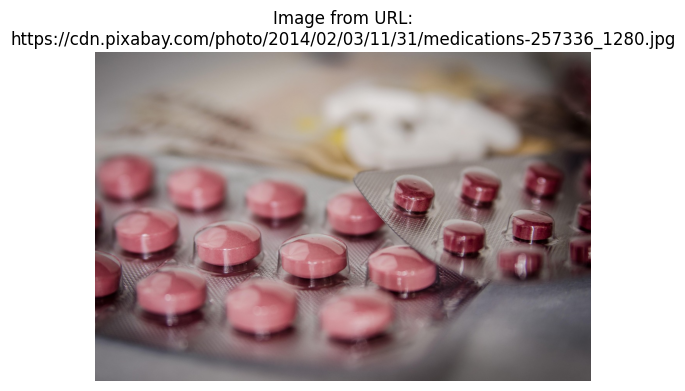

{'code': '00000', 'message': 'Image and text are matching', 'path': 'short_description path(address)', 'test_type': 'passed', 'type': 'Image-Text Match'}


In [ ]:
# Run the check
result = check_image_text_mismatch(sample_input)
print(result)

## corrected version

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Updated similarity threshold (between 0 and 1)
SIMILARITY_THRESHOLD = 0.25

In [ ]:
def load_image_from_url(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content)).convert("RGB")

def check_image_text_mismatch(data):
  provider = data["message"]["catalog"]["bpp/providers"][0]
  descriptor = provider["descriptor"]
  image_url = descriptor["images"][0]
  short_desc = descriptor["short_desc"]

  # Load and show the image
  image = load_image_from_url(image_url)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f"Image from URL:\n{image_url}")
  plt.show()

  # Preprocess for independent encoding
  inputs = processor(text=short_desc, images=image, return_tensors="pt", padding=True)

  # Encode separately
  with torch.no_grad():
    image_features = model.get_image_features(inputs["pixel_values"])
    text_features = model.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

  # Normalize embeddings
  image_features = image_features / image_features.norm(dim=-1, keepdim=True)
  text_features = text_features / text_features.norm(dim=-1, keepdim=True)

  # Compute cosine similarity
  similarity = cosine_similarity(image_features, text_features).item()
  print(f"Similarity Score: {similarity:.4f}")

  # Check if it's below threshold
  if similarity < SIMILARITY_THRESHOLD:
    return {
      "code": "99010",
      "message": "Description does not match predicted category: FOODS AND BEVERAGES > SNACKS > SAMOSA",
      "path": "short_description path(address)",
      "test_type": "recommendation",
      "type": "Image-Text Matching Error"
    }
  else:
    return {
      "code": "00000",
      "message": "Image and text are matching",
      "path": "short_description path(address)",
      "test_type": "passed",
      "type": "Image-Text Match"
    }

In [ ]:
# Example Input
sample_input = {
  "message": {
    "catalog": {
      "bpp/providers": [
        {
          "descriptor": {
            "images": ["https://cdn.pixabay.com/photo/2014/02/03/11/31/medications-257336_1280.jpg"],
            "long_desc": "combo of wings and burger",
            "short_desc": "fried combo"
          }
        }
      ]
    }
  }
}

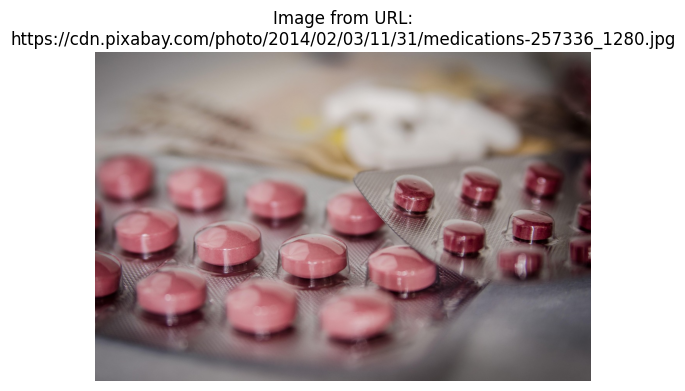

Similarity Score: 0.1595
{'code': '99010', 'message': 'Description does not match predicted category: FOODS AND BEVERAGES > SNACKS > SAMOSA', 'path': 'short_description path(address)', 'test_type': 'recommendation', 'type': 'Image-Text Matching Error'}


In [ ]:
# Run test
result = check_image_text_mismatch(sample_input)
print(result)